# 準備

In [1]:
!pip install japanize-matplotlib
!pip install optuna

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib 
import re
import unicodedata
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import lightgbm as lgb
import math
import optuna

     |████████████████████████████████| 4.1 MB 8.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=15b83093651b4bca7cbad53b736f4e600a7681b1dfd7b2b91d62db3767b1209b
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 308 kB 8.7 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 210 kB 57.4 MB/s 
     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 146 kB 36.9 MB/s 
     |████████████████████████████████| 113 kB 43.9 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=c9ef7013acc735474f51d1c1c1d060089c17539834035ed07185c27d2a624f23
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b0

In [61]:
import copy
import scipy.stats as stats

In [3]:
#RDKitの準備. とりあえず実行してください. 少々時間がかかります. 
!pip install kora
import kora.install.rdkit
from rdkit import rdBase
print(rdBase.rdkitVersion)

#RDKitと関連するライブラリをインポート
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, Descriptors
#以下は特に描画用
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG


!pip install mordred
from mordred import Calculator, descriptors

     |████████████████████████████████| 57 kB 3.6 MB/s 
     |████████████████████████████████| 60 kB 5.7 MB/s 
2020.09.1
     |████████████████████████████████| 128 kB 7.4 MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176725 sha256=3e1e09dabf7bffa969aa1a2fa8e7320c2ca5cdcfdbb0ac1c28e77a33180a6652
  Stored in directory: /root/.cache/pip/wheels/02/c0/2e/e7e3d63b431777712ebc128bc4deb9ac5cb19afc7c1ea341ec
Successfully built mordred


# データ読み込み

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/抗菌ペプチド情報_共同研究(寺山先生)_出水_修正版20220322.xlsx')



In [5]:
data.head()

,呼び名,番号,作成者,ペプチド配列,SMILES,大腸菌 (NZRC 3972),DH5a,緑膿菌,黄色ブドウ球菌,プロテウス菌,表皮ブドウ球菌,Proteus vulgaris,Salmonella enterica subsp.,Klebsiella pneumoniae（肺炎桿菌）,MDRP,溶血性,Δ[θ] ([θ]222/[θ]208),目的,備考,修正ペプチド配列
0,block,1,"蓜島, 後藤",H-KKKKKKKKKGGGLLALLALLA-NH2,[H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCC...,6.25,12.5,6.25,12.5,>100,6.25,NaN,NaN,NaN,NaN,25,0.545971,NaN,"U = Aib, S5 = (S)-pentenyl alanineなど, CD測定溶媒 H...",H-KKKKKKKKKGGGLLALLALLA-NH2
1,MAG2,2,"蓜島, 後藤, 平野",H-GIGKFLHSAKKFGKAFVGEIMNS-NH2,[H]NCC(N[C@]([C@@H](C)CC)([H])C(NCC(N[C@@H](CC...,3.125,3.125,12.5,100,>100,25,NaN,NaN,NaN,NaN,>100,0.966404,NaN,NaN,H-GIGKFLHSAKKFGKAFVGEIMNS-NH2
2,DL,3,"蓜島, 小澤",H-GIGKFLHSAKKFGKAFV-NH2,[H]NCC(N[C@]([H])(C(NCC(N[C@H](C(N[C@H](CC1=CC...,25,12.5,25,>100,>100,100,NaN,NaN,NaN,NaN,NaN,0.991295,NaN,"D体、L体交互, CD測定溶媒 H2O: TFE=1: 1 (小澤)",H-gIgKfLhSaKkFgKaFv-NH2
3,"17, D",4,"蓜島, 小澤, 後藤",H-GIGKFLHSAKKFGKAFV-NH2,[H]NCC(N[C@@]([H])(C(NCC(N[C@@H](C(N[C@H](CC1=...,3.125,3.125,3.125,50,>100,12.5,NaN,NaN,NaN,NaN,>100,0.823821,NaN,"全てD体, CD測定溶媒 H2O: TFE=1: 1 (小澤)",H-gigkflhsakkfgkafv-NH2
4,Aib,5,"蓜島, 後藤",H-GIGKFLHSUKKFGKUFV-NH2,[H]NCC(N[C@]([C@@H](C)CC)([H])C(NCC(N[C@@H](CC...,3.125,3.125,3.125,12.5,>100,3.125,NaN,NaN,NaN,NaN,>100,0.870000,NaN,"U=Aib, CD測定溶媒 H2O: TFE=1: 1 (蓜島)",H-GIGKFLHSUKKFGKUFV-NH2


In [6]:
data['Δ[θ] ([θ]222/[θ]208)']

0     0.545971
1     0.966404
2     0.991295
3     0.823821
4     0.870000
        ...   
78         NaN
79         NaN
80         NaN
81         NaN
82         NaN
Name: Δ[θ] ([θ]222/[θ]208), Length: 83, dtype: float64

# 前処理

In [7]:
peptide_list = data['修正ペプチド配列'][:82]
peptide_list

0                 H-KKKKKKKKKGGGLLALLALLA-NH2
1               H-GIGKFLHSAKKFGKAFVGEIMNS-NH2
2                     H-gIgKfLhSaKkFgKaFv-NH2
3                     H-gigkflhsakkfgkafv-NH2
4                     H-GIGKFLHSUKKFGKUFV-NH2
                       ...                   
77             H-KLLKKAX2KLLKKAX2KLLKKAX2-NH2
78             H-KLLKKX2GKLLKKX2GKLLKKX2G-NH2
79          H-KLLKKX2X2KLLKKX2X2KLLKKX2X2-NH2
80       H-KLX2KKX2X2KLX2KKX2X2KLX2KKX2X2-NH2
81    H-KX2X2KKX2X2KX2X2KKX2X2KX2X2KKX2X2-NH2
Name: 修正ペプチド配列, Length: 82, dtype: object

In [8]:
smiles_list = data['SMILES'][:82]
mol_list = [Chem.MolFromSmiles(smi) for smi in smiles_list]

アミノ酸記号http://nomenclator.la.coocan.jp/chem/text/aminosym.htm

修正方針

- 基本はL体ということで,大文字はL体, 小文字はD体とする

- U=Aib (全体的に統一されていたのでOK)

- 一箇所(71番)Z=AibがあったのでZ->Uへ

- Z=Ac6c (全体的に統一されていたのでOK)

- X0=L-homoserine-(O-allyl) (No.11,12)

- X1 = Dab (No.45,51,52,61,62)

- X2 = Sarcosine (No.)

- 架橋している場合, アミノ酸文字の後に=を入れる
  -- S5,S8の間には架橋が入る

- B=Ac5c (No.14)

- S5 = (S)-2-(4-pentenyl)Alanine

- R8 = (R)-2-(7-pentenyl)Alanine

- Orn (Orthinine?)が含まれている配列があるのでOに置き換え



特徴量への変換方針

2次構造予測スコアを特徴量に入れてしまう.

分割方法.
- まず'-'で分割. C末端, N末端は別処理. 
- AA配列の分
  - 数字が入っているか確認し, もし入っていたら数字入り要素を分割
  - 数字入り要素以外を1文字づつ分割

  - 用意したAAリストでindexを割り振る

- 架橋は別フラグを用意する.

- 特徴量の全体は, C末端情報, N末端情報, AA配列情報(indexの後に架橋しているかのbit,D体(0)L体(1)のbit, の繰り返し) 



In [100]:
#とりあえずL体だけで用意
AA_dict = {
  'A': 'Alanine',
  'C': 'Cysteine',
  'D': 'Aspartic acid',
  'E': 'Glutamic acid',
  'F': 'Phenylalanine',
  'G': 'Glycine',
  'H': 'Histidine',
  'I': 'Isoleucine',
  'K': 'Lysine',
  'L': 'Leucine',
  'M': 'Methionine',
  'N': 'Asparagine',
  'P': 'Proline',
  'Q': 'Glutamine',
  'R': 'Arginine',
  'S': 'Serine',
  'T': 'Threonine',
  'V': 'Valine',
  'W': 'Tryptophane',
  'Y': 'Tyrosine',
  'O': 'Orthinine',
  'X0': 'L-homoserine-(O-allyl)',
  'X1': 'Dab',
  'X2': 'Sarcosine',
  'B': 'Ac5c',
  'U': 'Aib',
  'Z': 'Ac6c',
  'S5': '(S)-2-(4-pentenyl)Alanine',
  'R8': '(R)-2-(7-pentenyl)Alanine',
}
#D体用に拡張
D_AA_dict = {}
for aa in AA_dict.keys():
  D_AA_dict[aa.lower()] = 'D-'+AA_dict[aa]

AA_dict.update(D_AA_dict)

#架橋用
AA_dict['='] = 'Link'

In [101]:
AA_keys = list(AA_dict.keys())
link_index_list = []
for st in ['S5', 'R8', 's5', 'r8', '=']:
  link_index_list.append(AA_keys.index(st))
print('link_index_list', link_index_list)


SR_index_list = []
for st in ['S', 'R', 's', 'r']:
  SR_index_list.append(AA_keys.index(st))
print('SR_index_list', SR_index_list)

link_index_list [27, 28, 56, 57, 58]
SR_index_list [15, 14, 44, 43]


In [102]:
ct_list, nt_list = [], []
for peptide in peptide_list:
  #remove '\xa0' and ' ' in peptide string
  peptide = unicodedata.normalize("NFKD", peptide).strip()
  ct,aa_list,nt = peptide.split('-')
  ct_list.append(ct)
  nt_list.append(nt)
ct_list = list(set(ct_list))
nt_list = list(set(nt_list))
print('ct_list', ct_list)
print('nt_list', nt_list)

ct_list ['Ac', 'H', 'CH3(CH2)10CO', 'CH3(CH2)16CO', 'CH3(CH2)4CO']
nt_list ['NH2']


In [103]:
peptide_feature_list = []
#for peptide in peptide_list[35:36]:
for peptide in peptide_list:
  print(peptide)
  peptide = unicodedata.normalize("NFKD", peptide).strip()
  ct,aa_list,nt = peptide.split('-')
  ct_index = ct_list.index(ct)
  nt_index = nt_list.index(nt)
  
  print(aa_list)
  ##Indexing AA-sequence
  tmp_list = []
  for i, AA_key in enumerate(AA_dict.keys()):
    res = re.finditer(AA_key, aa_list)
    for s in res:
        tmp_list.append([s.span()[0], i])
        print(i, AA_key, s.span()[0])
  tmp_list = sorted(tmp_list, key=lambda x:float(x[0]))

  #'S', 'S5'等の重複削除
  print('tmp_list', tmp_list)
  new_tmp_list = []
  for tmp in tmp_list:
    if tmp[0]+1 < len(aa_list):
      if tmp[1] in SR_index_list:
        if aa_list[tmp[0]+1] in ['5', '8']:
          continue
    new_tmp_list.append(tmp)
  tmp_list = new_tmp_list
  print('removed_tmp_list', tmp_list)
 

  AA_index_list = []
  link_list = []

  for pair in tmp_list:
    if pair[1] in link_index_list:
      link_list.append(len(AA_index_list)+1)
    if pair[1] not in [AA_keys.index('=')]:
      AA_index_list.append(pair[1])

  if len(link_list) == 0:
    link_list = [-1, -1]
  peptide_feature = [ct_index, nt_index] + link_list + AA_index_list
  print(peptide_feature)
  peptide_feature_list.append(peptide_feature)

H-KKKKKKKKKGGGLLALLALLA-NH2
KKKKKKKKKGGGLLALLALLA
0 A 14
0 A 17
0 A 20
5 G 9
5 G 10
5 G 11
8 K 0
8 K 1
8 K 2
8 K 3
8 K 4
8 K 5
8 K 6
8 K 7
8 K 8
9 L 12
9 L 13
9 L 15
9 L 16
9 L 18
9 L 19
tmp_list [[0, 8], [1, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8], [9, 5], [10, 5], [11, 5], [12, 9], [13, 9], [14, 0], [15, 9], [16, 9], [17, 0], [18, 9], [19, 9], [20, 0]]
removed_tmp_list [[0, 8], [1, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8], [9, 5], [10, 5], [11, 5], [12, 9], [13, 9], [14, 0], [15, 9], [16, 9], [17, 0], [18, 9], [19, 9], [20, 0]]
[1, 0, -1, -1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 9, 9, 0, 9, 9, 0, 9, 9, 0]
H-GIGKFLHSAKKFGKAFVGEIMNS-NH2
GIGKFLHSAKKFGKAFVGEIMNS
0 A 8
0 A 14
3 E 18
4 F 4
4 F 11
4 F 15
5 G 0
5 G 2
5 G 12
5 G 17
6 H 6
7 I 1
7 I 19
8 K 3
8 K 9
8 K 10
8 K 13
9 L 5
10 M 20
11 N 21
15 S 7
15 S 22
17 V 16
tmp_list [[0, 5], [1, 7], [2, 5], [3, 8], [4, 4], [5, 9], [6, 6], [7, 15], [8, 0], [9, 8], [10, 8], [11, 4], [12, 5], [13, 8], [14, 0], [15

In [104]:
#Check

AA_keys = list(AA_dict.keys())

for i, pf in enumerate(peptide_feature_list):
  aa_seq = ''
  for j, k in enumerate(pf[4:]):
    if j in pf[2:4]:
      aa_seq += '='
    aa_seq += AA_keys[k]
    

    
  seq = ct_list[pf[0]]+'-'+aa_seq+'-'+nt_list[pf[1]]
  print(i, seq)
  print(i, peptide_list[i])
  print('')

0 H-KKKKKKKKKGGGLLALLALLA-NH2
0 H-KKKKKKKKKGGGLLALLALLA-NH2

1 H-GIGKFLHSAKKFGKAFVGEIMNS-NH2
1 H-GIGKFLHSAKKFGKAFVGEIMNS-NH2

2 H-gIgKfLhSaKkFgKaFv-NH2
2 H-gIgKfLhSaKkFgKaFv-NH2

3 H-gigkflhsakkfgkafv-NH2
3 H-gigkflhsakkfgkafv-NH2

4 H-GIGKFLHSUKKFGKUFV-NH2
4 H-GIGKFLHSUKKFGKUFV-NH2

5 H-GIGKFLHSZKKFGKZFV-NH2
5 H-GIGKFLHSZKKFGKZFV-NH2

6 H-GIKKFLHSAKKFGKAFV-NH2
6 H-GIKKFLHSAKKFGKAFV-NH2

7 H-GIKKFLKSAKKFKKAFV-NH2
7 H-GIKKFLKSAKKFKKAFV-NH2

8 H-GIKKFLKSAKKFVKAFK-NH2
8 H-GIKKFLKSAKKFVKAFK-NH2

9 H-KKKLAKLKLGAKLKLKGKLGA-NH2
9 H-KKKLAKLKLGAKLKLKGKLGA-NH2

10 H-KKX0UKKX0U-NH2
10 H-KKX0UKKX0U-NH2

11 H-KKX0U=KKX0U-NH2
11 H-KKX0=UKKX0=U-NH2

12 H-KKUUKKU-NH2
12 H-KKUUKKU-NH2

13 H-KKBBKKB-NH2
13 H-KKBBKKB-NH2

14 H-KKZZKKZ-NH2
14 H-KKZZKKZ-NH2

15 H-GIGKFLHSAKKFGKAFVGEIDS-NH2
15 H-GIGKFLHSAKKFGKAFVGEIDS-NH2

16 Ac-KFLHSAKKF-NH2
16 Ac-KFLHSAKKF-NH2

17 Ac-AKKFGKAFV-NH2
17 Ac-AKKFGKAFV-NH2

18 Ac-GIGKFLHSAKKF-NH2
18 Ac-GIGKFLHSAKKF-NH2

19 Ac-KFLHSAKKFGKAFV-NH2
19 Ac-KFLHSAKKFGKAFV-NH2

20 Ac-G

In [105]:
#padding
max_len = np.max([len(v) for v in peptide_feature_list])
print('max_len', max_len)
for peptide_feature in peptide_feature_list:
  pad_len = max_len - len(peptide_feature)
  peptide_feature += [-2] * pad_len

max_len 29


In [106]:
for fl in peptide_feature_list:
  print(fl)

[1, 0, -1, -1, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 9, 9, 0, 9, 9, 0, 9, 9, 0, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 5, 8, 4, 9, 6, 15, 0, 8, 8, 4, 5, 8, 0, 4, 17, 5, 3, 7, 10, 11, 15, -2, -2]
[1, 0, -1, -1, 34, 7, 34, 8, 33, 9, 35, 15, 29, 8, 37, 4, 34, 8, 29, 4, 46, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 34, 36, 34, 37, 33, 38, 35, 44, 29, 37, 37, 33, 34, 37, 29, 33, 46, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 5, 8, 4, 9, 6, 15, 25, 8, 8, 4, 5, 8, 25, 4, 17, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 5, 8, 4, 9, 6, 15, 26, 8, 8, 4, 5, 8, 26, 4, 17, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 8, 8, 4, 9, 6, 15, 0, 8, 8, 4, 5, 8, 0, 4, 17, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 8, 8, 4, 9, 8, 15, 0, 8, 8, 4, 8, 8, 0, 4, 17, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 5, 7, 8, 8, 4, 9, 8, 15, 0, 8, 8, 4, 17, 8, 0, 4, 8, -2, -2, -2, -2, -2, -2, -2, -2]
[1, 0, -1, -1, 8, 8, 8, 9, 0, 8, 9, 8, 9, 5, 0, 8, 9, 8, 9, 8, 5, 8, 9, 5, 0, -2, 

# 新規ペプチド生成


In [16]:
#アミノ酸構造の準備 #Prolineは未対応
#L-体
AA_joint = {
  'A': '[1*]C',
  'C': '[1*]CS',
  'D': 'OC(=O)C[1*]',
  'E': 'OC(=O)CC[1*]',
  'F': '[1*]CC1=CC=CC=C1',
  'G': '[1*][H]',
  'H': '[1*]CC1=CN=CN1',
  'I': 'CC[C@H](C)[1*]',
  'K': 'NCCCC[1*]',
  'L': 'CC(C)C[1*]',
  'M': 'CSCC[1*]',
  'N': 'NC(=O)C[1*]',
  'P': 'Proline', #Prolineは未対応
  'Q': 'NC(=O)CC[1*]',
  'R': 'NC(N)=NCCC[1*]',
  'S': 'OC[1*]',
  'T': 'C[C@@H](O)[1*]',
  'V': 'CC(C)[1*]',
  'W': '[1*]CC1=CNC2=CC=CC=C12',
  'Y': 'OC1=CC=C(C[1*])C=C1',
  'O': 'NCCC[1*]',
  'X0': '[1*]CCOCC=C',
  'X1': 'NCC[1*]', 
  'X2': 'Sarcosine', #要対応 Nにメチル, CaのところはのところはGlycineと同じ([*1]H)
  'B': 'C1CC[1*]C1', #要対応 5員環にする
  'U': 'Aib', # 要対応 C(C)(C)にする
  'Z': 'C1CC[1*]CC1', # 要対応6員環にする 
  'S5': 'C[1*]CCC\C=[300*]', #向きは難しい...自信ない C[*1]CCCC=[*300]
  'R8': 'C[1*]CCCCCCC=[300*]', #C[*1]CCCCCCC=[*300] 
}
"""
{
    'D-I': 'CC[C@@H](C)[*1]'
}
"""

"\n{\n    'D-I': 'CC[C@@H](C)[*1]'\n}\n"

In [17]:
def make_joint_MC(base_mol, MC_mol, pep_len):

  for i in range(pep_len):
    #print(i)

    ####Ca-Cbを切って切ってjointを付ける#####
    
    matches = base_mol.GetSubstructMatches(MC_mol)[0]
    #print(matches)
    atom_index = matches[i*4 + 1]
    #print('atom_index', atom_index)
    Ca_atom = base_mol.GetAtomWithIdx(atom_index)
    #print(Ca_atom.GetSymbol(), atom_index)
    #print('with index', Chem.MolToSmiles(mol_with_atom_index(base_mol)))

    #for atom in Ca_atom.GetNeighbors():
    #  print('x:', atom.GetIdx(), atom.GetAtomicNum())

    c_beta_idx = [x.GetIdx() for x in Ca_atom.GetNeighbors() if x.GetIdx() not in list(matches)][0]
    atom_pair = [Ca_atom.GetIdx(), c_beta_idx]
    #print('atom_pair', atom_pair)
    bs = [base_mol.GetBondBetweenAtoms(atom_pair[0],atom_pair[1]).GetIdx()]
    #print(bs)
    fragments_mol = Chem.FragmentOnBonds(base_mol,bs,addDummies=True,dummyLabels=[(i+1,i+1)])
    try:
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    except:
      print("error")

    base_mol = fragments[0]

    ####Ca-Hを切って切ってjointを付ける#####
    matches = base_mol.GetSubstructMatches(MC_mol)[0]
    atom_index = matches[i*4 + 1]
    Ca_atom = base_mol.GetAtomWithIdx(atom_index)
    
    
    h_idx = [x.GetIdx() for x in Ca_atom.GetNeighbors() if x.GetAtomicNum() == 1][0]
    atom_pair = [Ca_atom.GetIdx(), h_idx]
    #print('atom_pair', atom_pair)
    bs = [base_mol.GetBondBetweenAtoms(atom_pair[0],atom_pair[1]).GetIdx()]
    #print(bs)
    fragments_mol = Chem.FragmentOnBonds(base_mol,bs,addDummies=True,dummyLabels=[(i+1+100,i+1+100)])
    try:
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    except:
      print("error")
    base_mol = fragments[0]

    ####N-Hを切って切ってjointを付ける#####
    matches = base_mol.GetSubstructMatches(MC_mol)[0]
    atom_index = matches[i*4 + 0]
    N_atom = base_mol.GetAtomWithIdx(atom_index)
    
    
    h_idx = [x.GetIdx() for x in N_atom.GetNeighbors() if x.GetAtomicNum() == 1][0]
    atom_pair = [N_atom.GetIdx(), h_idx]
    #print('atom_pair', atom_pair)
    bs = [base_mol.GetBondBetweenAtoms(atom_pair[0],atom_pair[1]).GetIdx()]
    #print(bs)
    fragments_mol = Chem.FragmentOnBonds(base_mol,bs,addDummies=True,dummyLabels=[(i+1+200,i+1+200)])
    try:
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    except:
      print("error")
    base_mol = fragments[0]


    #Chem.SanitizeMol(base_mol)
  base_mol = Chem.RemoveHs(base_mol)
  base_smi = Chem.MolToSmiles(base_mol)
  return base_smi, base_mol

In [23]:
def make_new_peptide(joint_MC_mol, AA_keys, AA_joint, input_aa_list):
  #各アミノ酸をつけるCaごとにX*が振られているので、アミノ酸をくっつける
  AA_key_list = [AA_keys[v] for v in input_aa_list[4:] if v>=0]


  linker_flag = 0
  for i in range(len(AA_key_list)):
    AA_key = AA_key_list[i]
    print('i', i, 'AA_key', AA_key)

    #N-methileに絡むのはX2のみなので先に処理処理
    if AA_key == 'X2':
      #### Main N-C ####
      c_joint_mol = Chem.MolFromSmiles('[1*]C')
      reaction_pattern = '[*:1][*'+str(i+1+200)+'].[*1][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([joint_MC_mol, c_joint_mol])
      joint_MC_mol = x[0][0]

      #### Main Ca-R ####
      h_joint_mol = Chem.MolFromSmiles('[1*][H]')
      reaction_pattern = '[*:1][*'+str(i+1)+'].[*1][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([joint_MC_mol, h_joint_mol])
      #print(x)
      joint_MC_mol = x[0][0]

      #### Main Ca-H ####
      h_joint_mol = Chem.MolFromSmiles('[1*][H]')
      reaction_pattern = '[*:1][*'+str(i+1+100)+'].[*1][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([joint_MC_mol, h_joint_mol])
      joint_MC_mol = x[0][0]


    else:
      #### Main N-H この処理はX2以外は共通 ####
      h_joint_mol = Chem.MolFromSmiles('[1*][H]')
      reaction_pattern = '[*:1][*'+str(i+1+200)+'].[*1][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([joint_MC_mol, h_joint_mol])
      joint_MC_mol = x[0][0]



      #if AA_key in ['P', 'X2', 'B', 'U', 'Z', 'S5', 'R8']:
      #  print('例外処理')
      if AA_key == 'B': #Caで5員環
          aa_joint = '[50*]CCCC[51*]'
          aa_joint_mol = Chem.MolFromSmiles(aa_joint)

          reaction_pattern = '[*:1][*'+str(i+1)+'].[*50][*:2] >> [*:1][*:2]'
          rxn = AllChem.ReactionFromSmarts(reaction_pattern)
          x = rxn.RunReactants([joint_MC_mol, aa_joint_mol])
          joint_MC_mol = x[0][0]

          reaction_pattern = '([*:1]-['+str(i+1+100)+'*].[51*]-[*:2])>>[*:1]-[*:2]'
          rxn = AllChem.ReactionFromSmarts(reaction_pattern)
          x = rxn.RunReactants([joint_MC_mol])
          joint_MC_mol = x[0][0]

      elif AA_key == 'U': #'Aib', # 要対応 C(C)(C)にする
        c_joint_mol = Chem.MolFromSmiles('[1*]C')
        
        #### Main Ca-R ####

        reaction_pattern = '[*:1][*'+str(i+1)+'].[*1][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, c_joint_mol])
        joint_MC_mol = x[0][0]

        #### Main Ca-H ####
        reaction_pattern = '[*:1][*'+str(i+1+100)+'].[*1][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, c_joint_mol])
        joint_MC_mol = x[0][0]

      elif AA_key == 'Z': #Caで6員環
        aa_joint = '[50*]CCCCC[51*]'
        aa_joint_mol = Chem.MolFromSmiles(aa_joint)

        reaction_pattern = '[*:1][*'+str(i+1)+'].[*50][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, aa_joint_mol])
        joint_MC_mol = x[0][0]

        reaction_pattern = '([*:1]-['+str(i+1+100)+'*].[51*]-[*:2])>>[*:1]-[*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol])
        joint_MC_mol = x[0][0]

#'S5': 'C[1*]CCC\C=[300*]', #向きは難しい...自信ない C[*1]CCCC=[*300]
#'R8': 'C[1*]CCCCCCC=[300*]', #C[*1]CCCCCCC=[*300] 

      elif AA_key == 'S5': 
        aa_joint = '[1*]CCCC=[300*]'
        aa_joint_mol = Chem.MolFromSmiles(aa_joint)

        reaction_pattern = '[*:1][*'+str(i+1)+'].[*1][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, aa_joint_mol])
        joint_MC_mol = x[0][0]

        if linker_flag == 1:
          reaction_pattern = '([*:1]=[300*].[300*]=[*:2])>>[*:1]=[*:2]'
          rxn = AllChem.ReactionFromSmarts(reaction_pattern)
          x = rxn.RunReactants([joint_MC_mol])
          joint_MC_mol = x[0][0]

        c_joint_mol = Chem.MolFromSmiles('[1*]C')
        reaction_pattern = '[*:1][*'+str(i+1+100)+'].[*1][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, c_joint_mol])
        joint_MC_mol = x[0][0]

        linker_flag = 1

      elif AA_key == 'R8': 
          aa_joint = '[1*]CCCCCCC=[300*]'
          aa_joint_mol = Chem.MolFromSmiles(aa_joint)

          reaction_pattern = '[*:1][*'+str(i+1)+'].[*1][*:2] >> [*:1][*:2]'
          rxn = AllChem.ReactionFromSmarts(reaction_pattern)
          x = rxn.RunReactants([joint_MC_mol, aa_joint_mol])
          joint_MC_mol = x[0][0]

          if linker_flag == 1:
            reaction_pattern = '([*:1]=[300*].[300*]=[*:2])>>[*:1]=[*:2]'
            rxn = AllChem.ReactionFromSmarts(reaction_pattern)
            x = rxn.RunReactants([joint_MC_mol])
            joint_MC_mol = x[0][0]

          c_joint_mol = Chem.MolFromSmiles('[1*]C')
          reaction_pattern = '[*:1][*'+str(i+1+100)+'].[*1][*:2] >> [*:1][*:2]'
          rxn = AllChem.ReactionFromSmarts(reaction_pattern)
          x = rxn.RunReactants([joint_MC_mol, c_joint_mol])
          joint_MC_mol = x[0][0]

          linker_flag = 1
     
        
      else:
        #### Main Ca-R ####
        aa_joint = AA_joint[AA_key]
        #print(aa_joint)
        aa_joint_mol = Chem.MolFromSmiles(aa_joint)

        reaction_pattern = '[*:1][*'+str(i+1)+'].[*1][*:2] >> [*:1][*:2]'
        #print(reaction_pattern)
        #print(aa_joint_mol)
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, aa_joint_mol])
        #print(x)
        joint_MC_mol = x[0][0]

        #### Main Ca-H ####
        h_joint_mol = Chem.MolFromSmiles('[1*][H]')
        reaction_pattern = '[*:1][*'+str(i+1+100)+'].[*1][*:2] >> [*:1][*:2]'
        rxn = AllChem.ReactionFromSmarts(reaction_pattern)
        x = rxn.RunReactants([joint_MC_mol, h_joint_mol])
        joint_MC_mol = x[0][0]


      


    #print(Chem.MolToSmiles(joint_MC_mol))
  joint_MC_mol = Chem.RemoveHs(joint_MC_mol)
  #print(Chem.MolToSmiles(joint_MC_mol))

  return Chem.MolToSmiles(joint_MC_mol), joint_MC_mol

In [24]:
def generate_new_peptitde(base_index, input_aa_list):

  pep_len = len([v for v in  peptide_feature_list[base_index][4:] if v >= 0])
  print('pep_len', pep_len)
  base_smiles = smiles_list[base_index]

  base_mol = Chem.MolFromSmiles(base_smiles)
  base_mol = Chem.AddHs(base_mol)

  MC_mol = Chem.MolFromSmiles('NCC(=O)'*(pep_len))
  matches = base_mol.GetSubstructMatches(MC_mol)[0]
  print(len(matches), matches)

  joint_MC_smi, joint_MC_mol = make_joint_MC(base_mol, MC_mol, pep_len)

  print('joint_MC_smi', joint_MC_smi)

  AA_keys = list(AA_dict.keys())
  peptide_smi, peptide_mol = make_new_peptide(joint_MC_mol, AA_keys, AA_joint, input_aa_list)

  print('peptide_smi', peptide_smi)

  return peptide_smi, peptide_mol

In [25]:
#出水先生に指定してもらったデータ
#番号9, H-GIKKFLKSAKKFVKAFK-NH2, 
#番号番号69 H-KLLKKAGKLLKKAGKLLKKAG-NH2 

#baseの指定と, 生成したいaa配列を指定する
#大前提: linker (S5, R8)は配列中に合わせて0個か2個しか出現しない.
#プロリンには対応できていない.
#L体のみに対応.

base_index = 8
#B:24, U:25, Z:26, S5:27, R8:28, 
input_aa_list = peptide_feature_list[base_index]
new_peptide_smi, new_peptide_mol = generate_new_peptitde(base_index, input_aa_list)


pep_len 17
68 (0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 19, 20, 21, 22, 28, 29, 30, 31, 39, 40, 41, 42, 47, 48, 49, 50, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 69, 70, 76, 77, 78, 79, 85, 86, 87, 88, 96, 97, 98, 99, 103, 104, 105, 106, 112, 113, 114, 115, 117, 118, 119, 120, 128, 129, 130, 131, 137, 139)
joint_MC_smi [1*]C([101*])(N[201*])C(=O)N([202*])[C@]([2*])([102*])C(=O)N([203*])[C@]([3*])([103*])C(=O)N([204*])[C@]([4*])([104*])C(=O)N([205*])[C@]([5*])([105*])C(=O)N([206*])[C@]([6*])([106*])C(=O)N([207*])[C@]([7*])([107*])C(=O)N([208*])[C@]([8*])([108*])C(=O)N([209*])[C@]([9*])([109*])C(=O)N([210*])[C@]([10*])([110*])C(=O)N([211*])[C@]([11*])([111*])C(=O)N([212*])[C@]([12*])([112*])C(=O)N([213*])[C@]([13*])([113*])C(=O)N([214*])[C@]([14*])([114*])C(=O)N([215*])[C@]([15*])([115*])C(=O)N([216*])[C@]([16*])([116*])C(=O)N([217*])[C@]([17*])([117*])C(N)=O
i 0 AA_key G
i 1 AA_key I
i 2 AA_key K
i 3 AA_key K
i 4 AA_key F
i 5 AA_key L
i 6 AA_key K
i 7 AA_key S
i 8 AA_key A
i 9 AA_key K
i 10 AA_k

In [26]:
#グリシン -H  [1*]-[H]
#アラニン -CH3 [1*]-C
#Lysine -CCCCN [1*]-CCCCN


#ベースになるものとして, Glyでないくっつ
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol


# 分子構造編集

In [27]:
def calc_smiles_skip_connection(smi, peptide_feature, skip = 4):
  
  pep_len = len([v for v in  peptide_feature[4:] if v >= 0])
  #print(pep_len, peptide_feature, smi)
  mol = Chem.MolFromSmiles(smi)

  #if the peptide has a linker, then cut it.
  linker_count = 0
  while mol.HasSubstructMatch(Chem.MolFromSmarts('[O][C:1]@[C:2]=[C:3]@[C:4][O]')): 
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('[O][C:1]@[C:2]=[C:3]@[C:4][O]'))
    #print(bis)
    for bs in bis:
      bs = [mol.GetBondBetweenAtoms(bs[2],bs[3]).GetIdx()]
      #print(bs)
      fragments_mol = Chem.FragmentOnBonds(mol,bs,addDummies=False)
    try:
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    except:
      return None
    mol = fragments[0]
    linker_count += 1

  #print('mol', Chem.MolToSmiles(mol))
  MC_smiles = Chem.MolFromSmiles('NC(=O)C'*(pep_len))

  #print(MC_smiles)

  matches = mol.GetSubstructMatches(MC_smiles)[0]
  #print(len(matches), matches)

  vertical_list = [Chem.MolFromSmiles('[H][1*]')]*skip
  #print([Chem.MolToSmiles(mol) for mol in vertical_list])
  #print(vertical_list)
  for i in range(pep_len):
    skip_base = i % skip
    #print(i, skip_base, i/skip)

    if i < pep_len - skip:
      bs = [mol.GetBondBetweenAtoms(matches[i*4 + 1],matches[i*4 + 3]).GetIdx(), mol.GetBondBetweenAtoms(matches[i*4 + 3],matches[i*4 + 4]).GetIdx()]
      fragments_mol = Chem.FragmentOnBonds(mol,bs,addDummies=True,dummyLabels=[(int(i/skip+1), int(i/skip+1)), (int(i/skip + 2), int(i/skip + 2))])
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
      for fragment in fragments:
        if '['+str(int(i/skip+1))+'*]' in Chem.MolToSmiles(fragment) and '['+str(int(i/skip+2))+'*]' in Chem.MolToSmiles(fragment):
          aa_fragment = fragment
          break

      reaction_pattern = '[*:1]['+str(int(i/skip+1))+'*].['+str(int(i/skip+1))+'*][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      vertical_list[skip_base] = rxn.RunReactants([vertical_list[skip_base], aa_fragment])[0][0]
    else:
      #print('[*:1]['+str(int(i/skip+1))+'*].['+str(int(i/skip+1))+'*][H] >> [*:1][H]')
      reaction_pattern = '[*:1]['+str(int(i/skip+1))+'*] >> [*:1][H]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      vertical_list[skip_base] = rxn.RunReactants([vertical_list[skip_base]])[0][0]
    #print([Chem.MolToSmiles(mol) for mol in vertical_list])
  vertical_list = [Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in vertical_list]
  return vertical_list

In [28]:
def calc_feature_skip_connection(smi, peptide_feature, skip, feature, descriptor_dimension = 2048):
  vertical_list = calc_smiles_skip_connection(smi, peptide_feature, skip = 4)
  
 
  vertical_feature_list = []
  for mol in vertical_list:
    #print(Chem.MolToSmiles(mol))
    if feature == 'Morgan_r2':
      vertical_feature_list.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension))
    elif feature == 'Morgan_r4':
      vertical_feature_list.append(AllChem.GetMorganFingerprintAsBitVect(mol, 4, descriptor_dimension))
    elif feature == 'MACCS':
      vertical_feature_list.append(AllChem.GetMACCSKeysFingerprint(mol))
    elif feature == 'Morgan_r2_count':
      vertical_feature_list.append(calc_MorganCount(mol, 2, descriptor_dimension))
    elif feature == 'Morgan_r4_count':
      vertical_feature_list.append(calc_MorganCount(mol, 4, descriptor_dimension))
  #print(vertical_feature_list)
  vertical_feature = np.mean(vertical_feature_list, axis = 0)
  return vertical_feature


In [29]:
def replaceP_smiles(smi, peptide_feature, base_atom = 'P'):
  pep_len = len([v for v in  peptide_feature[4:] if v >= 0])
  mol = Chem.MolFromSmiles(smi)
  tmp = Chem.MolFromSmiles('NC(=O)C'*(pep_len))
  
  #print('[N:1][C:2](=[O:3])[C:4] >> [N:1][C:2](=[O:3])[P:4]')
  mc_pattern, pc_pattern = '', ''
  for i in range(pep_len):
    mc_pattern += '[N:'+str(i*4+1)+'][C:'+str(i*4+2)+'](=[O:'+str(i*4+3)+'])[C:'+str(i*4+4)+']'
    pc_pattern += '[N:'+str(i*4+1)+'][C:'+str(i*4+2)+'](=[O:'+str(i*4+3)+'])[P:'+str(i*4+4)+']([H])([H])'

  reaction_pattern = mc_pattern + '>>' + pc_pattern
  rxn = AllChem.ReactionFromSmarts(reaction_pattern)
  x = rxn.RunReactants([mol])[0]
  #print(x)
  #print(Chem.MolToSmiles(x[0]))
  return Chem.MolToSmiles(x[0])

In [30]:
def calc_graph_connect(smi, peptide_feature, skip = 4):
  pep_len = len([v for v in  peptide_feature[4:] if v >= 0])
  mol = Chem.MolFromSmiles(smi)
  mol = Chem.AddHs(mol)
  Chem.SanitizeMol(mol)
  #print('H', Chem.MolToSmiles(mol))

  
  pc_pattern = 'NC(=O)P'*pep_len
  #print(pc_pattern)
  matches = mol.GetSubstructMatches(Chem.MolFromSmiles(pc_pattern))[0]
  #print(len(matches), pep_len, matches)

  

  def get_HbondIdx(mol, p_index):
    for bond in mol.GetAtomWithIdx(matches[p_index]).GetBonds():
      if bond.GetEndAtom().GetSymbol() == 'H':
        return mol.GetBondBetweenAtoms(matches[p_index],bond.GetEndAtom().GetIdx()).GetIdx()

  for i in range(pep_len - skip):
  #print('matches[0],matches[1]', matches[0],matches[1])
  #print([mol.GetBondBetweenAtoms(matches[3],bond.GetEndAtom().GetIdx()).GetIdx() for bond in mol.GetAtomWithIdx(matches[3]).GetBonds() if bond.GetEndAtom().GetSymbol() == 'H'])
    matches = mol.GetSubstructMatches(Chem.MolFromSmiles(pc_pattern))[0]
    #print(len(matches), i*4+3, i*4+ 3 + skip*4)
    bs = [get_HbondIdx(mol, i*4+3), get_HbondIdx(mol,  i*4+ 3 + skip*4)]
    #bs = [mol.GetBondBetweenAtoms(matches[3],bond.GetEndAtom().GetIdx()).GetIdx() for bond in mol.GetAtomWithIdx(matches[3]).GetBonds() if bond.GetEndAtom().GetSymbol() == 'H']
    fragments_mol = Chem.FragmentOnBonds(mol,bs,addDummies=True,dummyLabels=[(1,1), (2,2)])
    fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    #print(Chem.MolToSmiles(Chem.RemoveHs(fragments[0])))
    reaction_pattern = "([*1]-[P:1].[P:2]-[*2])>>[P:1]-[P:2]" #"([C:1]=[C;H2].[C:2]=[C;H2])>>[*:1]=[*:2]" #" [1*][*:1].[*:2][2*] >> [*:1][*:2]"
    rxn = AllChem.ReactionFromSmarts(reaction_pattern)
    mol = rxn.RunReactants([fragments[0]])[0][0]
    #print(mol)
  x = Chem.RemoveHs(mol)
  #print(Chem.MolToSmiles(x))
  return Chem.MolToSmiles(x)
  """

  matches = mol.GetSubstructMatches(MC_smiles)[0]
  
  bs = [mol.GetBondBetweenAtoms(matches[i*4 + 1],matches[i*4 + 3]).GetIdx(), mol.GetBondBetweenAtoms(matches[i*4 + 3],matches[i*4 + 4]).GetIdx()]
      fragments_mol = Chem.FragmentOnBonds(mol,bs,addDummies=True,dummyLabels=[(int(i/skip+1), int(i/skip+1)), (int(i/skip + 2), int(i/skip + 2))])
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
      for fragment in fragments:
        if '['+str(int(i/skip+1))+'*]' in Chem.MolToSmiles(fragment) and '['+str(int(i/skip+2))+'*]' in Chem.MolToSmiles(fragment):
          aa_fragment = fragment
          break

      reaction_pattern = '[*:1]['+str(int(i/skip+1))+'*].['+str(int(i/skip+1))+'*][*:2] >> [*:1][*:2]'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      vertical_list[skip_base] = rxn.RunReactants([vertical_list[skip_base], aa_fragment])[0][0]
    else:
  """

In [31]:
def calc_smiles_woMC(smi, peptide_feature, base_atom = 'P'):
  pep_len = len([v for v in  peptide_feature[4:] if v >= 0])
  mol = Chem.MolFromSmiles(smi)
  tmp = Chem.MolFromSmiles('NC(=O)C'*(pep_len))

  #if the peptide has a linker, then cut it.
  linker_count = 0
  while mol.HasSubstructMatch(Chem.MolFromSmarts('[O][C:1]@[C:2]=[C:3]@[C:4][O]')): 

    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('[O][C:1]@[C:2]=[C:3]@[C:4][O]'))
    print(bis)
    for bs in bis:
      bs = [mol.GetBondBetweenAtoms(bs[2],bs[3]).GetIdx()]
      print(bs)
      fragments_mol = Chem.FragmentOnBonds(mol,bs,addDummies=True,dummyLabels=[(300+linker_count, 300+linker_count)])
  
    try:
      fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    except:
      return None
  
    mol = fragments[0]
    linker_count += 1
  
  #Aib, Ac6cについてもlinkerのような処理を行う. 一旦切っておいてラベルをつけておき最後に付け直す 
  #Aib
  Aib_count = 0
  while mol.HasSubstructMatch(Chem.MolFromSmarts('[C][C&h0](!@[C])(N)C=O')): 
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('[C][C&h0](!@[C])(N)C=O'))
    print(bis)
    bs = bis[0]
    #bond = [mol.GetBondBetweenAtoms(bs[0],bs[1]).GetIdx()]
    bond = [mol.GetBondBetweenAtoms(bs[1],bs[2]).GetIdx(), mol.GetBondBetweenAtoms(bs[0],bs[1]).GetIdx()]
    fragments_mol = Chem.FragmentOnBonds(mol,bond,addDummies=True,dummyLabels=[(400+Aib_count, 400++Aib_count), (400+Aib_count, 400+Aib_count)])
    fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    mol = fragments[0]

    Aib_count += 1

  #Ac6c
  Ac6c_count = 0
  while mol.HasSubstructMatch(Chem.MolFromSmarts('NC1(CCCCC1)C=O')): 
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('NC1(CCCCC1)C=O'))
    print(bis)
    bs = bis[0]
    print(bs)
    bond = [mol.GetBondBetweenAtoms(bs[1],bs[2]).GetIdx()]
    print(bond)
    fragments_mol = Chem.FragmentOnBonds(mol,bond,addDummies=True,dummyLabels=[(600+Ac6c_count, 600+Ac6c_count)])
  
    fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    mol = fragments[0]
    Ac6c_count += 1

  
  #Ac5c
  Ac5c_count = 0
  while mol.HasSubstructMatch(Chem.MolFromSmarts('NC1(CCCC1)C=O')): 
    bis = mol.GetSubstructMatches(Chem.MolFromSmarts('NC1(CCCC1)C=O'))
    print(bis)
    bs = bis[0]
    print(bs)
    bond = [mol.GetBondBetweenAtoms(bs[1],bs[2]).GetIdx()]
    print(bond)
    fragments_mol = Chem.FragmentOnBonds(mol,bond,addDummies=True,dummyLabels=[(500+Ac5c_count, 500+Ac5c_count)])
  
    fragments = Chem.GetMolFrags(fragments_mol,asMols=True)
    mol = fragments[0]
    Ac5c_count += 1
  print(Chem.MolToSmiles(mol))
  



    
  
  matches = mol.GetSubstructMatches(tmp)
  print(len(matches), matches)
  rep_core = AllChem.ReplaceCore(mol, tmp)

  side_mol = Chem.GetMolFrags(rep_core, asMols=True)
  Draw.MolsToGridImage([x for x in side_mol])

  print([Chem.MolToSmiles(x) for x in side_mol])
  side_smi_list = [Chem.MolToSmiles(x) for x in side_mol]
  ordered_side_smi_list = []
  for i in range(len(side_mol)):
    for side_smi in side_smi_list:
      if '['+str(i+1)+'*]' in side_smi:
        ordered_side_smi_list.append(side_smi)
        break
  print(ordered_side_smi_list)
  ordered_side_mol_list = [Chem.MolFromSmiles(smi) for smi in ordered_side_smi_list]

  for i in range(len(side_mol)):
    if i == 0:
      if base_atom == 'P':
        reaction_pattern = '[*:1][*:100].[*:2][*:101] >> [*201][P]([*:100])([*:101])'
      elif base_atom == 'C':
        reaction_pattern = '[*:1][*:100].[*:2][*:101] >> [*201][C]([*:100])([*:101])'
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([ordered_side_mol_list[0], ordered_side_mol_list[1]])[0][0]
      print(i, Chem.MolToSmiles(x), Chem.MolToSmarts(x))
    elif i < len(side_mol) - 2:
      if base_atom == 'P':
        reaction_pattern = '[*:'+str(i+2)+'][*:100].[*:'+str(200+i)+'][P:101] >>  [*'+str(200+i+1)+'][P]([*:100])([P:101])' #  [P:20'+str(i+1)+']([*:100])[P:20'+str(i)+'][*:101]'
      elif base_atom == 'C':
        reaction_pattern = '[*:'+str(i+2)+'][*:100].[*:'+str(200+i)+'][C:101] >>  [*'+str(200+i+1)+'][C]([*:100])([C:101])' #  [P:20'+str(i+1)+']([*:100])[P:20'+str(i)+'][*:101]'
      
      print(i, reaction_pattern)
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([ordered_side_mol_list[i+1], x])[0][0]
      print(i, Chem.MolToSmiles(x), Chem.MolToSmarts(x))
    elif i == len(side_mol) - 2:
      if base_atom == 'P':
        reaction_pattern = '[*:'+str(i+2)+'][*:100].[*:'+str(200+i)+'][P:101] >>  [P]([*:100])([P:101])'
      elif base_atom == 'C':
        reaction_pattern = '[*:'+str(i+2)+'][*:100].[*:'+str(200+i)+'][C:101] >>  [C]([*:100])([C:101])'
      print(i, reaction_pattern)
      rxn = AllChem.ReactionFromSmarts(reaction_pattern)
      x = rxn.RunReactants([ordered_side_mol_list[i+1], x])[0][0]
      print(i, Chem.MolToSmiles(x))
  


  #一番最後にloop, メチル化(Aib(25), Ac6c(26)の処理)
  #linker
  for count in range(linker_count):
    #通常処理
    rxn = AllChem.ReactionFromSmarts('([*:1]=['+str(300+count)+'*].['+str(300+count)+'*]=[*:2])>>[*:1]=[*:2]')
    x = rxn.RunReactants([x])[0][0]
  

  #Aib
  #if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(400+count)+'*][P:1]([P:3])[P:4][C:5][C:6][C:7][C:8][C:9]['+str(400+count)+'*]')):
  for count in range(Aib_count):
    #通常処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(400+count)+'*][P:1][P:2]['+str(400+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(400+count)+'*][P:1][P:2](['+str(400+count)+'*])[P:3]>>[C][P:1]([C])[P:3]')
      x = rxn.RunReactants([x])[0][0]
    #終端にいる場合の処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(400+count)+'*][P:1]['+str(400+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(400+count)+'*][P:1]['+str(400+count)+'*]>>[C][P:1][C]')
      x = rxn.RunReactants([x])[0][0]
  
  #Ac6c
  for count in range(Ac6c_count):
    #通常処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(600+count)+'*][P:1]([P:3])[P:4][C:5][C:6][C:7][C:8][C:9]['+str(600+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(600+count)+'*][P:1]([P:3])[P:4][C:5][C:6][C:7][C:8][C:9]['+str(600+count)+'*]>>[P:3][P:4]1([C:5][C:6][C:7][C:8][C:9]1)')
      x = rxn.RunReactants([x])[0][0]
    #終端にいる場合の処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(600+count)+'*][P:1][C:5][C:6][C:7][C:8][C:9]['+str(600+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(600+count)+'*][P:1][C:5][C:6][C:7][C:8][C:9]['+str(600+count)+'*]>>[P:1]1([C:5][C:6][C:7][C:8][C:9]1)')
      x = rxn.RunReactants([x])[0][0]
  #Ac5c
  for count in range(Ac5c_count):
    #通常処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(500+count)+'*][P:1]([P:3])[P:4][C:5][C:6][C:7][C:8]['+str(500+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(500+count)+'*][P:1]([P:3])[P:4][C:5][C:6][C:7][C:8]['+str(500+count)+'*]>>[P:3][P:4]1([C:5][C:6][C:7][C:8]1)')
      x = rxn.RunReactants([x])[0][0]
    #終端にいる場合の処理
    if x.HasSubstructMatch(Chem.MolFromSmarts('['+str(500+count)+'*][P:1][C:5][C:6][C:7][C:8]['+str(500+count)+'*]')):
      rxn = AllChem.ReactionFromSmarts('['+str(500+count)+'*][P:1][C:5][C:6][C:7][C:8]['+str(500+count)+'*]>>[P:1]1([C:5][C:6][C:7][C:8]1)')
      x = rxn.RunReactants([x])[0][0]
    

  return Chem.MolToSmiles(x)
  #Draw.MolsToGridImage([ordered_side_mol_list[0], ordered_side_mol_list[1], x])
  

In [32]:
#for i in range(len(smiles_list)):
#5(Ac6c),8(主鎖検出でエラー, 元のSMILES修正でOK), 11(Aib, 架橋),13(Ac5c)
smiles_woMC_list = []
for i in range(len(smiles_list)):
  print(i, smiles_list[i])
  seq_smi = calc_smiles_woMC(smiles_list[i], peptide_feature_list[i])
  smiles_woMC_list.append(seq_smi)

0 [H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(NCC(NCC(NCC(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N)=O)C)=O)=O)=O)C)=O)=O)=O)C)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O
CC(C)C[C@H](NC(=O)CNC(=O)CNC(=O)CNC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C)C(N)=O
1 ((132, 131, 133, 130, 129, 128, 135, 123, 122, 121, 136, 116, 115, 114, 137, 113, 112, 111, 139, 106, 105, 104, 140, 99, 98, 97, 141, 96, 95, 94, 143, 89, 88, 87, 144, 82, 81, 80, 145, 79, 78, 77, 146, 76, 75, 74, 147, 73, 72, 71, 148, 65, 64, 63, 149, 57, 56, 55, 150, 49, 48, 47, 151, 

In [33]:
smiles_repP_list = []
for i in range(len(smiles_list)):
  print(i, smiles_list[i])
  seq_smi = replaceP_smiles(smiles_list[i], peptide_feature_list[i])
  smiles_repP_list.append(seq_smi)

0 [H]N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(NCC(NCC(NCC(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@@H](CC(C)C)C(N[C@H](C(N)=O)C)=O)=O)=O)C)=O)=O)=O)C)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O)=O
1 [H]NCC(N[C@]([C@@H](C)CC)([H])C(NCC(N[C@@H](CCCCN)C(N[C@H](C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@@H](CO)C(N[C@H](C(N[C@@H](CCCCN)C(N[C@@H](CCCCN)C(N[C@H](C(NCC(N[C@@H](CCCCN)C(N[C@H](C(N[C@H](C(N[C@@H](C(C)C)C(NCC(N[C@@H](CCC(O)=O)C(N[C@]([C@@H](C)CC)([H])C(N[C@H](C(N[C@@H](CC(N)=O)C(N[C@@H](CO)C(N)=O)=O)=O)CCSC)=O)=O)=O)=O)=O)CC1=CC=CC=C1)=O)C)=O)=O)=O)CC2=CC=CC=C2)=O)=O)=O)C)=O)=O)CC3=CN=CN3)=O)=O)CC4=CC=CC=C4)=O)=O)=O)=O
2 [H]NCC(N[C@]([H])(C(NCC(N[C@H](C(N[C@H](CC1=CC=CC=C1)C(N[C@H](C(N[C@H](CC2=CN=CN2)C(N[C@H](C(N[C@H](C)C(N[C@H](C(N[C@@H](C(N[C@@H](CC3=CC=CC=C3)C(NCC(N[C@H](C(N[C@H](C)C(N[C@@H](CC4=CC=CC=C4)C(N[C@@H](C(N)=O)C(C)C

# 特徴量計算

In [34]:
#Calculation of Fingerprint, descriptor
descriptor_dimension = 1024

def calc_MorganCount(mol, r = 2, dimension = 2048):
  info = {}
  _fp = AllChem.GetMorganFingerprint(mol, r, bitInfo=info)
  count_list = [0] * dimension
  for key in info:
    pos = key % dimension
    count_list[pos] += len(info[key])
  return count_list

radial = 4

#original smiles
Morgan_r2_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension) for mol in mol_list]
Morgan_r4_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radial, descriptor_dimension) for mol in mol_list]
MACCS_fp = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mol_list]
Morgan_r2_count = [calc_MorganCount(mol, 2, descriptor_dimension) for mol in mol_list]
Morgan_r4_count = [calc_MorganCount(mol, radial, descriptor_dimension) for mol in mol_list]

#smiles_woMC
mol_woMC_list = [Chem.MolFromSmiles(smi) for smi in smiles_woMC_list]
woMC_Morgan_r2_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension) for mol in mol_woMC_list]
woMC_Morgan_r4_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radial, descriptor_dimension) for mol in mol_woMC_list]
woMC_MACCS_fp = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mol_woMC_list]
woMC_Morgan_r2_count = [calc_MorganCount(mol, 2, descriptor_dimension) for mol in mol_woMC_list]
woMC_Morgan_r4_count = [calc_MorganCount(mol, radial, descriptor_dimension) for mol in mol_woMC_list]

#smiles_repP
mol_repP_list = [Chem.MolFromSmiles(smi) for smi in smiles_repP_list]
repP_Morgan_r2_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension) for mol in mol_repP_list]
repP_Morgan_r4_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radial, descriptor_dimension) for mol in mol_repP_list]
repP_MACCS_fp = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mol_repP_list]
repP_Morgan_r2_count = [calc_MorganCount(mol, 2, descriptor_dimension) for mol in mol_repP_list]
repP_Morgan_r4_count = [calc_MorganCount(mol, radial, descriptor_dimension) for mol in mol_repP_list]

#smiles_repP_skip4
mol_repP_skip4_list = [Chem.MolFromSmiles(calc_graph_connect(smi, peptide_feature, skip = 4)) for smi, peptide_feature in zip(smiles_repP_list, peptide_feature_list)]
repP_skip4_Morgan_r2_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension) for mol in mol_repP_skip4_list]
repP_skip4_Morgan_r4_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radial, descriptor_dimension) for mol in mol_repP_skip4_list]
repP_skip4_MACCS_fp = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mol_repP_skip4_list]
repP_skip4_Morgan_r2_count = [calc_MorganCount(mol, 2, descriptor_dimension) for mol in mol_repP_skip4_list]
repP_skip4_Morgan_r4_count = [calc_MorganCount(mol, radial, descriptor_dimension) for mol in mol_repP_skip4_list]

#smiles_repP_skip7
mol_repP_skip7_list = [Chem.MolFromSmiles(calc_graph_connect(smi, peptide_feature, skip = 7)) for smi, peptide_feature in zip(smiles_repP_list, peptide_feature_list)]
repP_skip7_Morgan_r2_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, descriptor_dimension) for mol in mol_repP_skip7_list]
repP_skip7_Morgan_r4_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radial, descriptor_dimension) for mol in mol_repP_skip7_list]
repP_skip7_MACCS_fp = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mol_repP_skip7_list]
repP_skip7_Morgan_r2_count = [calc_MorganCount(mol, 2, descriptor_dimension) for mol in mol_repP_skip7_list]
repP_skip7_Morgan_r4_count = [calc_MorganCount(mol, radial, descriptor_dimension) for mol in mol_repP_skip7_list]




In [35]:
#vertical_feature
"""
v_skip4_Morgan_r2_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r2', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip4_Morgan_r4_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r4', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip4_Morgan_r2_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r2_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip4_Morgan_r4_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r4_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip4_MACCS_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'MACCS') for i in range(len(smiles_list))]

v_skip7_Morgan_r2_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'Morgan_r2', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip7_Morgan_r4_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'Morgan_r4', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip7_Morgan_r2_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'Morgan_r2_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip7_Morgan_r4_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'Morgan_r4_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]
v_skip7_MACCS_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'MACCS') for i in range(len(smiles_list))]
"""

"\nv_skip4_Morgan_r2_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r2', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]\nv_skip4_Morgan_r4_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r4', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]\nv_skip4_Morgan_r2_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r2_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]\nv_skip4_Morgan_r4_count = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'Morgan_r4_count', descriptor_dimension = descriptor_dimension) for i in range(len(smiles_list))]\nv_skip4_MACCS_fp = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'MACCS') for i in range(len(smiles_list))

In [36]:
def calc_mordred_descriptor(mol_list):
  #mordred
  calc = Calculator(descriptors, ignore_3D = True)
  mordred_df = calc.pandas(mol_list)

  #modredののerrorをNaNで置き換え
  df_descriptors = mordred_df.astype(str)
  masks = df_descriptors.apply(lambda d: d.str.contains('[a-zA-Z]' ,na=False))
  df_descriptors = df_descriptors[~masks]
  df_descriptors = df_descriptors.astype(float)
  modred_descriptor = df_descriptors.dropna(axis=1, how='any')

  return modred_descriptor

In [37]:
#mordred_descriptor = calc_mordred_descriptor(mol_list)
#woMC_mordred_descriptor = calc_mordred_descriptor(mol_woMC_list)
#repP_mordred_descriptor = calc_mordred_descriptor(mol_repP_list)
#repP_skip4_mordred_descriptor = calc_mordred_descriptor(mol_repP_skip4_list)
#repP_skip7_mordred_descriptor = calc_mordred_descriptor(mol_repP_skip7_list)

#v_skip4_mordred_descriptor = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 4, feature = 'mordred') for i in range(len(smiles_list))]
#v_skip7_mordred_descriptor = [calc_feature_skip_connection(smiles_list[i], peptide_feature_list[i], skip = 7, feature = 'mordred') for i in range(len(smiles_list))]


# 予測モデル構築準備

In [38]:
#physboのインポート
#pipでインストール
!pip3 install physbo
import physbo

from sklearn import preprocessing 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for physbo: filename=physbo-1.0.1-cp37-cp37m-linux_x86_64.whl size=341921 sha256=c3f954b7ae5f021c7771aa665a4ac0f9de8eb3654a45fef82240d491742388c4
  Stored in directory: /root/.cache/pip/wheels/e3/1c/09/6a40470c5f2705129a491a6e91b7514152b580313ff9698cb8
Successfully built physbo


In [39]:
def GP_predict(train_X, test_X, train_y, test_y):

  cov = physbo.gp.cov.gauss(train_X,ard = False )
  mean = physbo.gp.mean.const()
  lik = physbo.gp.lik.gauss()
  gp = physbo.gp.model(lik=lik,mean=mean,cov=cov)
  config = physbo.misc.set_config()

  gp.fit(train_X, train_y, config)
  gp.print_params()
  gp.prepare(train_X, train_y)

  train_fmean = gp.get_post_fmean(train_X, train_X) 
  train_fcov = gp.get_post_fcov(train_X, train_X)

  test_fmean = gp.get_post_fmean(train_X, test_X) 
  test_fcov = gp.get_post_fcov(train_X, test_X)

  return [train_fmean, train_fcov], [test_fmean, test_fcov] 

In [40]:
def calc_prediction_model(smiles_type, model, feature, fold_n, target_index, value_log = False, standardize = False):

  target_name = data.keys()[target_index]
  exp_list = data[target_name][:82]
  print(target_name)

  #数値データの修正
  filled_index_list = []
  exp_modified_list = []
  for i, v in enumerate(exp_list):
    if str(v)[0] == '>':
      exp_modified_list.append(float(str(v)[1:])*2)
      filled_index_list.append(i)
    elif str(v)[0] == '<':
      exp_modified_list.append(float(str(v)[1:])/2)
      filled_index_list.append(i)
    else:
      if not math.isnan(v):
        filled_index_list.append(i)
      exp_modified_list.append(v)
  print(len(filled_index_list))
  if value_log == True:
    exp_modified_list = np.log10(exp_modified_list)
  plt.hist(np.array(exp_modified_list)[filled_index_list])
  plt.title(target_name+' Log10='+str(value_log))
  plt.xlabel(target_name)
  plt.ylabel('frequency')
  if target_name == 'Δ[θ] ([θ]222/[θ]208)':
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/helix-like_dist_log'+str(value_log)+'.png', dpi = 300)
  else:
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/'+target_name+'_dist_log'+str(value_log)+'.png', dpi = 300)
  plt.show()


  print('feature', feature, smiles_type)
  if smiles_type == 'original':
    if feature == 'one-hot':
      X = np.array(peptide_feature_list)[filled_index_list]
    elif feature == 'Morgan_r2':
      X = np.array(Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = mordred_descriptor.values[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(Morgan_r4_count)[filled_index_list]
    elif feature == 'MACCS+Morgan_r4_count':
      X0 = np.array(MACCS_fp)[filled_index_list]
      X1 = np.array(Morgan_r4_count)[filled_index_list]
      X = np.concatenate([X0, X1], axis = 1)
  if smiles_type == 'smiles_woMC':
    if feature == 'Morgan_r2':
      X = np.array(woMC_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(woMC_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(woMC_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = woMC_mordred_descriptor.values[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(woMC_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(woMC_Morgan_r4_count)[filled_index_list]
  if smiles_type == 'smiles_repP':
    if feature == 'Morgan_r2':
      X = np.array(repP_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(repP_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(repP_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = repP_mordred_descriptor.values[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(repP_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(repP_Morgan_r4_count)[filled_index_list]
  if smiles_type == 'smiles_repP_skip4':
    if feature == 'Morgan_r2':
      X = np.array(repP_skip4_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(repP_skip4_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(repP_skip4_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = repP_skip4_mordred_descriptor.values[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(repP_skip4_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(repP_skip4_Morgan_r4_count)[filled_index_list]
  if smiles_type == 'smiles_repP_skip7':
    if feature == 'Morgan_r2':
      X = np.array(repP_skip7_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(repP_skip7_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(repP_skip7_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = repP_skip7_mordred_descriptor.values[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(repP_skip7_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(repP_skip7_Morgan_r4_count)[filled_index_list]
  if smiles_type == 'vertical_skip7':
    if feature == 'Morgan_r2':
      X = np.array(v_skip7_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(v_skip7_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(v_skip7_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = np.array(v_skip7_mordred_descriptor)[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(v_skip7_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(v_skip7_Morgan_r4_count)[filled_index_list]
  if smiles_type == 'vertical_skip4':
    if feature == 'Morgan_r2':
      X = np.array(v_skip4_Morgan_r2_fp)[filled_index_list]
    elif feature == 'Morgan_r4':
      X = np.array(v_skip4_Morgan_r4_fp)[filled_index_list]
    elif feature == 'MACCS':
      X = np.array(v_skip4_MACCS_fp)[filled_index_list]
    elif feature == 'mordred':
      X = np.array(v_skip4_mordred_descriptor)[filled_index_list]
    elif feature == 'Morgan_r2_count':
      X = np.array(v_skip4_Morgan_r2_count)[filled_index_list]
    elif feature == 'Morgan_r4_count':
      X = np.array(v_skip4_Morgan_r4_count)[filled_index_list]


  """
  PCA_dim_reduction = True
  print(100, len(X[0]))
  #n_components = np.min([100, len(X[0])])
  n_components = 35
  if PCA_dim_reduction:
    # PCAで次元削減
    print('PCA calc')
    pca = PCA(n_components=n_components, svd_solver='arpack')
    X = pca.fit_transform(X)
  """

  if model == 'physbo' and standardize:
    
    ss = preprocessing.StandardScaler()
    X = ss.fit_transform(X)
  
  y = np.array(exp_modified_list)[filled_index_list]

  print(X)
  print(y)

  from sklearn.model_selection import KFold
  kf = KFold(n_splits = fold_n, shuffle = True, random_state=0)

  y_pred_list = []
  y_test_list = []
  y_index_list = []
    
  def objective(trial):
    params = {
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    train_model.set_params(**params)
    scores = cross_val_score(train_model, X_train, y_train, cv=cv,
                            scoring='neg_mean_squared_error', fit_params=fit_params, n_jobs=-1)
    return scores.mean()
    
  for train_index, test_index in kf.split(X):
    print(train_index, test_index)
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    if model == 'RF':
      train_model = RandomForestRegressor()
      train_model.fit(X_train, y_train)
    elif model == 'lightgbm':
      seed = 0
      train_model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression',
                      random_state=seed, n_estimators=100)
      fit_params = {
          'verbose': 2,
          'early_stopping_rounds': 10,
          'eval_metric': 'mean_squared_error',
          'eval_set': [(X_train, y_train)]
          }
      cv = KFold(n_splits=5, shuffle=True, random_state=seed)
      study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=seed))
      study.optimize(objective, n_trials=200)
      best_params = study.best_trial.params
      train_model.set_params(**best_params)
      train_model.fit(X_train, y_train)


      #train_model = lgb.LGBMRegressor() # モデルのインスタンスの作成
      #train_model.fit(X_train, y_train) # モデルの学習
      y_pred = train_model.predict(X_test)
      y_train_pred = train_model.predict(X_train)

      y_pred_list += list(y_pred)
      y_test_list += list(y_test)

    elif model == 'physbo':
      [y_train_pred, y_train_pred_cov], [y_pred, y_pred_cov] = GP_predict(X_train, X_test, y_train, y_test)
      train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
      train_r = np.corrcoef(y_train, y_train_pred)[0][1]
      print('train_rmse', train_rmse, 'train_r', train_r)

      y_pred_list += list(y_pred)
      y_test_list += list(y_test)


    y_index_list += list(test_index)
    #r2 = r2_score(y_test, y_pred),
    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #print(r2, rmse)
    r = np.corrcoef(y_test_list, y_pred_list)[0][1]
    r2 = r2_score(y_test_list, y_pred_list)
    #auc = roc_auc_score(y_test_list, y_pred_list)
    rmse = np.sqrt(mean_squared_error(y_test_list, y_pred_list))
    print(len(y_pred_list), 'r', r, 'r2', r2, 'RMSE', rmse, smiles_type, model, feature, fold_n, target_index)
    


  # Feature Importance
  #fti = clf_rf.feature_importances_   

  r = np.corrcoef(y_test_list, y_pred_list)[0][1]
  r2 = r2_score(y_test_list, y_pred_list)
  #auc = roc_auc_score(y_test_list, y_pred_list)

  rmse = np.sqrt(mean_squared_error(y_test_list, y_pred_list))
  print('RESULT', model, feature, fold_n, target_index)
  print('r2', r2, 'r', r, 'rmse', rmse)
  print('\n\n\n\n\n\n\n\n\n\n\n')

  plt.scatter(y_test_list, y_pred_list)
  plt.plot([np.min(y_test_list), np.max(y_test_list)], [np.min(y_test_list), np.max(y_test_list)])
  for i in range(len(y_test_list)):
    plt.annotate(str(i+1), (y_test_list[i]+0.02, y_pred_list[i]+0.02))
  plt.title(target_name+' (N='+str(len(y_test_list))+', model = '+model+') r='+str(round(r, 3)))
  plt.grid()
  if value_log:
    plt.xlabel('Experimental value (log)')
    plt.ylabel('Predicted value (log)')
  else:
    plt.xlabel('Experimental value')
    plt.ylabel('Predicted value')
  plt.axes().set_aspect('equal')
  if target_name == 'Δ[θ] ([θ]222/[θ]208)':
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/helix-like_feature'+feature+'_CV'+str(fold_n)+'_model'+model+'_smile'+smiles_type+'_scatter.png', dpi = 300)
  else:
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/'+target_name+'_feature'+feature+'_CV'+str(fold_n)+'_model'+model+'_smile'+smiles_type+'_scatter.png', dpi = 300)
  plt.show()


# 予測精度検証

In [ ]:
#model list: 'RF', 'lightgbm'
#feature list: 'Morgan_r2', 'Morgan_r4','Morgan_r2_count', 'Morgan_r4_count', 'MACCS', 'Morgan_r2_MACCS', 'one-hot', 'mordred'

#fold_n: fold num of cross-validation

#target_index
#5:'大腸菌 (NZRC 3972)', 6:'DH5a', 7:'緑膿菌', '黄色ブドウ球菌', 'プロテウス菌', 
#'表皮ブドウ球菌', 'Proteus vulgaris', 'Salmonella enterica subsp.', 'Klebsiella pneumoniae（肺炎桿菌）', 'MDRP', 15: '溶血性', 16: Δ[θ] ([θ]222/[θ]208)

#活性値にlog10を入れるか否か否か
value_log = False
#smiles_type = 'vertical_skip4' #'original', 'smiles_repP_skip7', 'smiles_woMC', 'vertical_skip4', 'vertical_skip7'
model = 'physbo'
fold_n = 10
for smiles_type in ['smiles_repP_skip7']:
  for target_index in [16]:
    for feature in ['Morgan_r2', 'Morgan_r4', 'Morgan_r2_count', 'Morgan_r4_count', 'MACCS']:# ['Morgan_r2', 'Morgan_r4', 'Morgan_r2_count', 'Morgan_r4_count', 'MACCS', 'mordred']:#['one-hot', 'mordred', 'Morgan_r2', 'Morgan_r4', 'MACCS']:
      calc_prediction_model(smiles_type, model, feature, fold_n, target_index, value_log, standardize = False)

Δ[θ] ([θ]222/[θ]208)
74


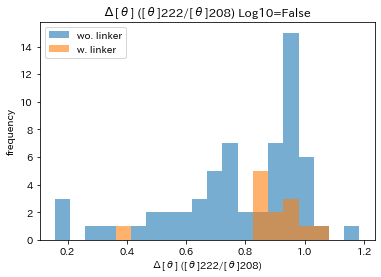

In [ ]:
target_index = 16
value_log = False
target_name = data.keys()[target_index]
exp_list = data[target_name][:82]
print(target_name)

#数値データの修正
filled_index_list = []
exp_modified_list = []
for i, v in enumerate(exp_list):
  if str(v)[0] == '>':
    exp_modified_list.append([float(str(v)[1:])*2, peptide_feature_list[i][2]])
    filled_index_list.append(i)
  elif str(v)[0] == '<':
    exp_modified_list.append([float(str(v)[1:])/2, peptide_feature_list[i][2]])
    filled_index_list.append(i)
  else:
    if not math.isnan(v):
      filled_index_list.append(i)
    exp_modified_list.append([v, peptide_feature_list[i][2]])

print(len(filled_index_list))
if value_log == True:
  exp_modified_list = np.log10(exp_modified_list)
max = np.max(np.array(exp_modified_list)[filled_index_list][:,0])
min = np.min(np.array(exp_modified_list)[filled_index_list][:,0])
#plt.hist(np.array(exp_modified_list)[filled_index_list][:,0], label = 'all', alpha = 0.6, bins = np.arange(min, max, (max-min)/20))
plt.hist([v[0] for v in np.array(exp_modified_list)[filled_index_list] if v[1] < 0], label = 'wo. linker', alpha = 0.6, bins = np.arange(min, max+0.01, (max-min)/20))
plt.hist([v[0] for v in np.array(exp_modified_list)[filled_index_list] if v[1] > 0], label = 'w. linker', alpha = 0.6, bins = np.arange(min, max+0.01, (max-min)/20))

#plt.hist(exp_modified_nonlinker_list, label = 'wo. linker', alpha = 0.6, bins = np.arange(0, 1.2, 0.05))
#plt.hist(exp_modified_linker_list, label = 'w. linker', alpha = 0.6, bins = np.arange(0, 1.2, 0.05))
#plt.hist(exp_modified_nonlinker_list, label = 'wo. linker', alpha = 0.6)
#plt.hist(exp_modified_linker_list, label = 'w. linker', alpha = 0.6)


plt.legend()
plt.title(target_name+' Log10='+str(value_log))
plt.xlabel(target_name)
plt.ylabel('frequency')
if target_name == 'Δ[θ] ([θ]222/[θ]208)':
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/helix-like_dist_log'+str(value_log)+'.png', dpi = 300)
else:
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/'+target_name+'_dist_log'+str(value_log)+'.png', dpi = 300)
plt.show()

In [96]:
smiles_list[base_index]

'[H]NCC(=O)N[C@@]([H])([C@@H](C)CC)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CO)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)N[C@@H](CCCCN)C(N)=O'

# BOによる推薦

In [109]:
#候補ペプチドの準備

#出水先生に指定してもらったデータ
#番号9, H-GIKKFLKSAKKFVKAFK-NH2, 
#番号番号69 H-KLLKKAGKLLKKAGKLLKKAG-NH2 

#baseの指定と, 生成したいaa配列を指定する
#大前提: linker (S5, R8)は配列中に合わせて0個か2個しか出現しない.
#プロリンには対応できていない.
#L体のみに対応.

base_index = 8
print(input_aa_list)
#B:24, U:25, Z:26, S5:27, R8:28, 
input_aa_list = peptide_feature_list[base_index]
pep_len = len([v for v in input_aa_list[4:] if v >= 0])

new_peptide_mol_list, new_peptide_smi_list = [], []
cand_data_list = []
for i in range(pep_len):
  for un in [24, 25, 26]:
    input_aa_list = copy.deepcopy(peptide_feature_list[base_index])
    input_aa_list[4+i] = un
    new_peptide_smi, new_peptide_mol = generate_new_peptitde(base_index, input_aa_list)
    cand_data_list.append([i, ['B', 'U', 'Z'][un - 24], new_peptide_smi])
    new_peptide_mol_list.append(new_peptide_mol)
    new_peptide_smi_list.append(new_peptide_smi)


[1, 0, -1, -1, 5, 7, 8, 8, 4, 9, 8, 15, 0, 8, 8, 4, 17, 8, 0, 4, 8, -2, -2, -2, -2, -2, -2, -2, -2]
pep_len 17
68 (0, 1, 2, 3, 4, 5, 10, 11, 12, 13, 19, 20, 21, 22, 28, 29, 30, 31, 39, 40, 41, 42, 47, 48, 49, 50, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 69, 70, 76, 77, 78, 79, 85, 86, 87, 88, 96, 97, 98, 99, 103, 104, 105, 106, 112, 113, 114, 115, 117, 118, 119, 120, 128, 129, 130, 131, 137, 139)
joint_MC_smi [1*]C([101*])(N[201*])C(=O)N([202*])[C@]([2*])([102*])C(=O)N([203*])[C@]([3*])([103*])C(=O)N([204*])[C@]([4*])([104*])C(=O)N([205*])[C@]([5*])([105*])C(=O)N([206*])[C@]([6*])([106*])C(=O)N([207*])[C@]([7*])([107*])C(=O)N([208*])[C@]([8*])([108*])C(=O)N([209*])[C@]([9*])([109*])C(=O)N([210*])[C@]([10*])([110*])C(=O)N([211*])[C@]([11*])([111*])C(=O)N([212*])[C@]([12*])([112*])C(=O)N([213*])[C@]([13*])([113*])C(=O)N([214*])[C@]([14*])([114*])C(=O)N([215*])[C@]([15*])([115*])C(=O)N([216*])[C@]([16*])([116*])C(=O)N([217*])[C@]([17*])([117*])C(N)=O
i 0 AA_key B
i 1 AA_key I
i 2 AA_key K


In [110]:
Cand_Morgan_r4_count = [calc_MorganCount(mol, 4, 1024) for mol in new_peptide_mol_list]

In [111]:
#target_index
#5:'大腸菌 (NZRC 3972)', 6:'DH5a', 7:'緑膿菌', '黄色ブドウ球菌', 'プロテウス菌', 
#'表皮ブドウ球菌', 'Proteus vulgaris', 'Salmonella enterica subsp.', 'Klebsiella pneumoniae（肺炎桿菌）', 'MDRP', 15: '溶血性', 16: Δ[θ] ([θ]222/[θ]208)

smiles_type = 'original'
model = 'physbo'
feature = 'Morgan_r4_count'
target_index = 15
value_log = True
standardize = False

target_name = data.keys()[target_index]
exp_list = data[target_name][:82]
print(target_name)

#数値データの修正
filled_index_list = []
exp_modified_list = []
for i, v in enumerate(exp_list):
  if str(v)[0] == '>':
    exp_modified_list.append(float(str(v)[1:])*2)
    filled_index_list.append(i)
  elif str(v)[0] == '<':
    exp_modified_list.append(float(str(v)[1:])/2)
    filled_index_list.append(i)
  else:
    if not math.isnan(v):
      filled_index_list.append(i)
    exp_modified_list.append(v)
print(len(filled_index_list))
if value_log == True:
  exp_modified_list = np.log10(exp_modified_list)

溶血性
57


In [112]:
X = np.array(Morgan_r4_count)[filled_index_list]
X_cand = np.array(Cand_Morgan_r4_count)

if model == 'physbo' and standardize:  
  ss = preprocessing.StandardScaler()
  X = ss.fit_transform(X)
  X_cand = ss.fit_transform(np.array(Cand_Morgan_r4_count))
y = np.array(exp_modified_list)[filled_index_list]

print(X)
print(y)

[[ 0 24  0 ...  0  1  0]
 [ 1 23  0 ...  0  0  0]
 [ 0 17  0 ...  0  0  0]
 ...
 [ 0 21  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]]
[ 1.39794001  2.30103     2.30103     2.30103     0.49485002  2.30103
  2.          0.49485002  1.69897     1.69897     0.79588002  0.49485002
  0.1931246   0.49485002  0.79588002 -0.7212464   0.49485002  0.79588002
  1.69897     1.39794001  0.79588002  2.30103     2.30103     1.69897
  2.          1.69897     1.69897     1.39794001  1.39794001  2.30103
  2.30103    -0.1079054  -0.1079054   1.69897     1.69897     1.69897
  1.09691001  1.69897     1.39794001  2.30103     2.30103    -0.7212464
 -0.1079054   2.30103     2.30103     2.30103     0.1931246  -0.1079054
  0.1931246   1.09691001 -0.1079054  -0.1079054   2.30103     2.30103
  2.30103     2.30103     2.30103   ]


In [113]:
[y_pred_train, y_pred_cov_train], [y_pred, y_pred_cov] = GP_predict(X, X_cand, y, [0 for i in range(len(X_cand))])

print('train_rmse', train_rmse, 'train_r', train_r)

Start the initial hyper parameter searching ...
Done

Start the hyper parameter learning ...
0 -th epoch marginal likelihood 49.34794499638516
50 -th epoch marginal likelihood 48.55196486112632
100 -th epoch marginal likelihood 48.00961729358562
150 -th epoch marginal likelihood 47.61783254959237
200 -th epoch marginal likelihood 47.316382798734054
250 -th epoch marginal likelihood 47.07580258943128
300 -th epoch marginal likelihood 46.8810941294874
350 -th epoch marginal likelihood 46.72348273941061
400 -th epoch marginal likelihood 46.59675804496254
450 -th epoch marginal likelihood 46.49586426496013
500 -th epoch marginal likelihood 46.416429878179
Done



likelihood parameter =   [-1.95453642]
mean parameter in GP prior:  [1.350093]
covariance parameter in GP prior:  [3.1674577  0.07645554]




NameError: ignored

In [114]:
def get_EI_list(train_Y, pred_y, sigma2_pred):
  prediction = pred_y
  sig = sigma2_pred**0.5

  gamma = (prediction - np.max(train_Y)) / sig
  ei = sig*(gamma*stats.norm.cdf(gamma) + stats.norm.pdf(gamma))

  return ei

In [115]:
print(y_pred[0::3])

[1.97829235 1.75648844 1.71058053 1.60396882 1.70442831 1.64893551
 1.69885212 1.50159272 1.52008838 1.59633799 1.59947219 1.62630585
 1.47122402 1.62829798 1.40634731 1.65896972 1.94316386]


[2.75329821e-02 1.14145051e-01 1.91989148e-02 7.38023251e-03
 6.96148355e-02 3.52630967e-03 5.10157516e-03 9.83488654e-02
 2.25450830e-03 1.85035795e-03 7.73913612e-02 7.24440913e-04
 9.60164828e-03 1.28343761e-01 4.80351381e-03 3.59980069e-03
 5.25565453e-02 1.45060586e-03 6.25491946e-03 9.06597243e-02
 3.08582776e-03 5.15464102e-04 2.65189445e-02 1.63320792e-04
 3.30501914e-05 4.71424868e-03 1.68515251e-06 1.83700589e-03
 5.91341258e-02 7.23380636e-04 1.84718025e-03 7.32914468e-02
 7.52414709e-04 6.61519728e-03 9.85852839e-02 3.39215194e-03
 6.37601581e-04 1.97667404e-02 2.07419759e-04 3.44144682e-03
 5.24513658e-02 1.70205519e-03 3.87526479e-06 2.77211607e-03
 1.55383983e-07 7.18477950e-03 9.42352293e-02 3.64428970e-03
 2.55463589e-02 1.50616847e-01 1.56942103e-02] [1.97829235 2.31035877 1.88770576 1.75648844 2.1810388  1.65792737
 1.71058053 2.2555125  1.60734343 1.60396882 2.20831339 1.50027601
 1.70442831 2.25416952 1.60195696 1.64893551 2.11805728 1.55184517
 1.69885212 2.225275

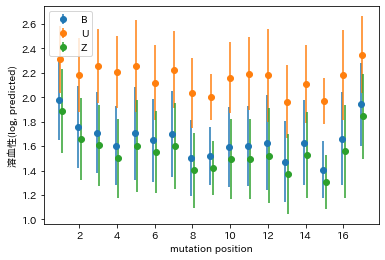

[1.50616847e-01 1.28343761e-01 1.14145051e-01 9.85852839e-02
 9.83488654e-02 9.42352293e-02 9.06597243e-02 7.73913612e-02
 7.32914468e-02 6.96148355e-02 5.91341258e-02 5.25565453e-02
 5.24513658e-02 2.75329821e-02 2.65189445e-02 2.55463589e-02
 1.97667404e-02 1.91989148e-02 1.56942103e-02 9.60164828e-03
 7.38023251e-03 7.18477950e-03 6.61519728e-03 6.25491946e-03
 5.10157516e-03 4.80351381e-03 4.71424868e-03 3.64428970e-03
 3.59980069e-03 3.52630967e-03 3.44144682e-03 3.39215194e-03
 3.08582776e-03 2.77211607e-03 2.25450830e-03 1.85035795e-03
 1.84718025e-03 1.83700589e-03 1.70205519e-03 1.45060586e-03
 7.52414709e-04 7.24440913e-04 7.23380636e-04 6.37601581e-04
 5.15464102e-04 2.07419759e-04 1.63320792e-04 3.30501914e-05
 3.87526479e-06 1.68515251e-06 1.55383983e-07]
[49 13  1 34  7 46 19 10 31  4 28 16 40  0 22 48 37  2 50 12  3 45 33 18
  6 14 25 47 15  5 39 35 20 43  8  9 30 27 41 17 32 11 29 36 21 38 23 24
 42 26 44]
[['16' 'U'
  'CC[C@H](C)[C@H](NC(=O)CN)C(=O)N[C@@H](CCCCN)C(=O)N

In [119]:
ei_list = get_EI_list(y, y_pred, y_pred_cov)
print(ei_list, y_pred, y_pred_cov)

plt.errorbar(np.array(range(1, len(y_pred[0::3]) + 1))-0.07, y_pred[0::3], yerr = (y_pred_cov**0.5)[0::3], fmt='o', label = 'B')
plt.errorbar(range(1, len(y_pred[1::3]) + 1), y_pred[1::3], yerr = (y_pred_cov**0.5)[1::3], fmt='o', label = 'U')
plt.errorbar(np.array(range(1, len(y_pred[2::3]) + 1))+0.07, y_pred[2::3], yerr = (y_pred_cov**0.5)[2::3], fmt='o', label = 'Z')

plt.legend()
plt.xlabel('mutation position')
plt.ylabel('溶血性(log, predicted)')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/data/fig/bo_溶血性_test.png', dpi = 300)
plt.show()

print(np.sort(ei_list)[::-1])
print(np.argsort(ei_list)[::-1])
print(np.array(cand_data_list)[np.argsort(ei_list)[::-1]])

In [ ]:
cand_data_list